# MACHINE LEARNING FOR TIME SERIES FORECASTING 
# APPLICATION ON SOLAR IRRADIANCE

## Plan
### 1- Introduction
### 2- Classical methodes for forecasting
### 3- Maching learning
### 4- Conclusion

# 1- Introduction
### 1-1 Time series definition 

Time series is a set of observations which are distinguished by the particular role played by the order (chronology) in which they were collected: they are observations made at fixed intervals $ h $, at time $ t_ {0 }, t_ {0} + h, ..., t_ {0} + (n - 1) h $.

A time series follows the following pattern:
	
\begin{matrix}
t_{0}     &   t_{0} + h   & ... & t_{0} + (n - 1)h     \\
\downarrow   &   \downarrow    & ... & \downarrow             \\
Y_{t_{0}} & Y_{t_{0}+h}   & ... & Y_{t_{0}+(n - 1)h} \\
\downarrow  &   \downarrow    & ... & \downarrow             \\
Y_{1}     &     Y_{2}     & ... & Y_{n}                \\
\end{matrix}

The prediction of a time series at time $n + h$ is denoted $\hat{Y}_{n}(h)$ and, in general, is different from the real value $Y_{n + h}$.   
To measure this difference, we will define the __forecast error__ by the difference $Y_{n+h} - \hat{Y}_{n}(h) := e(h)$

### 1-2 What do we want to do with it?

The study of time series may have the following non-exclusive objectives:

- Understanding the past: explaining the variations observed.
- Study the link with other series.
- Predict future (near) values.

### 1-3 Into solar energy forecasting

- The global situation of climate change is becoming increasingly serious as a result of global warming.
	
- The integration of solar energy into electricity networks requires reliable forecast information of solar resources. 
	
- The goal from forecasting solar energy is to quantify the available energy and allowing it to optimally manage the transition between intermittent and conventional energies.

# 2- Classical methodes for forecasting

Machine learning methods can be used for classification and forecasting on time series problems.

Before exploring machine learning methods for time series, it is a good idea to ensure you have exhausted classical linear time series forecasting methods. Classical time series forecasting methods may be focused on linear relationships, nevertheless, they are sophisticated and perform well on a wide range of problems, assuming that your data is suitably prepared and the method is well configured.

This part is structured as a cheat sheet to give you just enough information on each method to get started with a working code example. And all code examples are in Python and use the Statsmodels library (for this part).

### Overview 

This cheat sheet demonstrates 8 different classical time series forecasting methods; they are:

1. Autoregression (AR)
2. Moving Average (MA)
3. Autoregressive Moving Average (ARMA)
4. Autoregressive Integrated Moving Average (ARIMA)
5. Seasonal Autoregressive Integrated Moving-Average (SARIMA)
6. Simple Exponential Smoothing (SES)
7. Holt's Exponential Smoothing (HES)
8. Holt Winter’s Exponential Smoothing (HWES)

Each method is presented in a consistent manner.

This includes:

__Description:__ A short and precise description of the technique.  
__Python Code:__ A short working example of fitting the model and making a prediction in Python.


### Dataset 
Before we start descriping the classical models, first I want to load the data that we are going to use as an exemple.   
Note that all these methods need to be tuned for optimal results.

For this part we will be using the daily cases of Corona virus in Morocco up to today. And we will use each model to predict the next infected cases for the next day.

Let's start loading the data from the main source.

In [1]:
import pandas as pd
# Loading the Data from the source
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
df = pd.read_csv(url)
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,15205,15750,16509,17267,18054,18969,19551,20342,20917,21459
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,1137,1143,1164,1184,1197,1212,1232,1246,1263,1299
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,9394,9513,9626,9733,9831,9935,10050,10154,10265,10382
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,764,765,844,851,852,852,852,852,852,852
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,86,86,86,86,86,86,88,91,92,96


In [2]:
# Selecting the country Morocco
df = df[df["Country/Region"]=="Morocco"]
cumulative_daily_cases = df.iloc[:, 43:].transpose()
cumulative_daily_cases.head()

,163
3/1/20,0
3/2/20,1
3/3/20,1
3/4/20,1
3/5/20,2


In [3]:
# Checking if there are any missing values
cumulative_daily_cases.isnull().sum()

163    0
dtype: int64

In [4]:
# Making the dates look more suitable
cumulative_daily_cases.index = pd.to_datetime(cumulative_daily_cases.index)
cumulative_daily_cases.head()

,163
2020-03-01,0
2020-03-02,1
2020-03-03,1
2020-03-04,1
2020-03-05,2


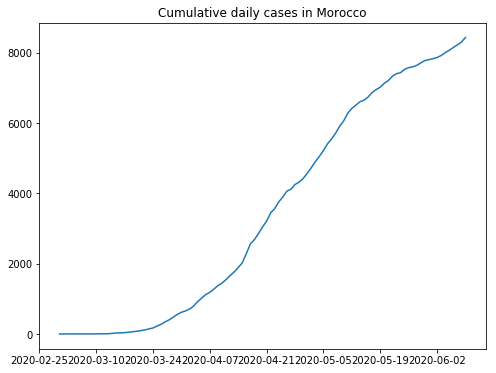

In [31]:
# Visualizing the cumulative daily cases

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

plt.plot(cumulative_daily_cases)
plt.title("Cumulative daily cases in Morocco");

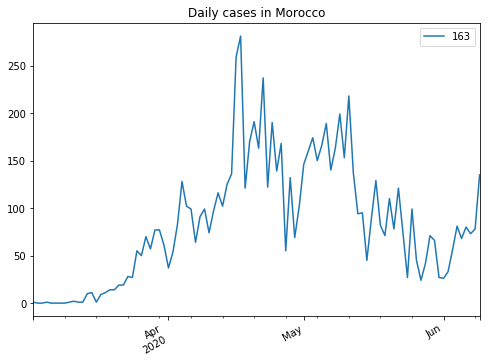

In [32]:
# Getting the daily cases
daily_cases = cumulative_daily_cases.diff()
daily_cases = daily_cases.iloc[1:]

# Visualizing the daily cases
daily_cases.plot(subplots=True)
plt.title("Daily cases in Morocco");

In [7]:
# Now we get only the observations and drop the dates.
data = daily_cases.to_numpy()
data.shape

(100, 1)

Now that we have the data prepared to use, next stup is to go through the models one by one and explore their codes.

## 2-1 Autoregression (AR) 
The autoregression (AR) method models the next step in the sequence as a linear function of the observations at prior time steps.

\begin{equation}
	Y_{t} = c + \phi_{1}Y_{t-1} + \phi_{2}Y_{t-2} + ... + \phi_{p}Y_{t-p} + \epsilon_{t},	
\end{equation}

The notation for the model involves specifying the order of the model $p$ as a parameter to the $AR$ function, e.g. $AR(p)$. For example, $AR(1)$ is a first-order autoregression model.

The method is suitable for univariate time series without trend and seasonal components.

### Python Code

In [8]:
# AR example
from statsmodels.tsa.ar_model import AutoReg

# fit model
model = AutoReg(data, lags=1)
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)

[126.04789426]


## 2-2 Moving Average (MA)

The moving average (MA) method models the next step in the sequence as a linear function of the residual errors from a mean process at prior time steps.

\begin{equation}
Y_{t} = \mu + \epsilon_{t} + \theta_{1}\epsilon_{t-1} + \theta_{2}\epsilon_{t-2} + ... + \theta_{q}\epsilon_{t-q}	
\end{equation}

A moving average model is different from calculating the moving average of the time series.

The notation for the model involves specifying the order of the model $q$ as a parameter to the $MA$ function, e.g. $MA(q)$. For example, $MA(1)$ is a first-order moving average model.

The method is suitable for univariate time series without trend and seasonal components.

### Python Code
We can use the ARMA class to create an MA model and setting a zeroth-order AR model. We must specify the order of the MA model in the order argument.

In [9]:
# MA example
from statsmodels.tsa.arima_model import ARMA

# fit model
model = ARMA(data, order=(0, 1))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)

[112.35114526]


## 2-3 Autoregressive Moving Average (ARMA)

The Autoregressive Moving Average (ARMA) method models the next step in the sequence as a linear function of the observations and resiudal errors at prior time steps.

\begin{equation}
Y_{t} =  \phi_{1}Y_{t-1} + \phi_{2}Y_{t-2} + ... + \phi_{p}Y_{t-p} + \epsilon_{t} + \theta_{1}\epsilon_{t-1} + \theta_{2}\epsilon_{t-2} + ... + \theta_{q}\epsilon_{t-q},	
\end{equation}

It combines both Autoregression (AR) and Moving Average (MA) models.

The notation for the model involves specifying the order for the $AR(p)$ and $MA(q)$ models as parameters to an $ARMA$ function, e.g. $ARMA(p, q)$. An $ARIMA$ model can be used to develop $AR$ or $MA$ models.

The method is suitable for univariate time series without trend and seasonal components.

### Python Code

In [10]:
# ARMA example
from statsmodels.tsa.arima_model import ARMA

# fit model
model = ARMA(data, order=(2, 1))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)

[102.81977067]


## 2-4 Autoregressive Integrated Moving Average (ARIMA)

The Autoregressive Integrated Moving Average (ARIMA) method models the next step in the sequence as a linear function of the differenced observations and residual errors at prior time steps.

\begin{equation}
\phi_{p}(B)(1 - B)^{d}Y_{t} = \theta_{0} + \theta_{q}(B)\epsilon_{t},
\end{equation}
where, 
$$\phi_{p}(B) = (1 - \phi_{1}B - \phi_{2}B^{2} - ... - \phi_{p}B^{p}),$$
and, 
$$\theta_{q}(B) = (1 +  \theta_{1}B + \theta_{2}B^{2} + ... + \theta_{q}B^{q})$$.


- The random error $\epsilon_{t} $ is a white noise process.
- $\phi_{i}\{i = 1, 2, ..., p\}$, $\theta_{i}\{i = 0, 1, 2, ..., q\}$ are the model parameters.
- The backshift operator $B^{j}Y_{t} = Y_{t-j}$.

It combines both Autoregression $(AR)$ and Moving Average $(MA)$ models as well as a differencing pre-processing step of the series to make the time series stationary, called integration ($I$).

The notation for the model involves specifying the order for the $AR(p)$, $I(d)$, and $MA(q)$ models as parameters to an $ARIMA$ function, e.g. $ARIMA(p, d, q)$. An $ARIMA$ model can also be used to develop $AR$, $MA$, and $ARMA$ models.

The method is suitable for univariate time series with trend and without seasonal components.

### Python Code

In [11]:
# ARIMA example
from statsmodels.tsa.arima_model import ARIMA

# fit model
model = ARIMA(data, order=(1, 1, 1))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(len(data), len(data), typ='levels')
print(yhat)

[105.77485568]


## 2-5 Seasonal Autoregressive Integrated Moving-Average (SARIMA)

The Seasonal Autoregressive Integrated Moving Average (SARIMA) method models the next step in the sequence as a linear function of the differenced observations, errors, differenced seasonal observations, and seasonal errors at prior time steps.

\begin{equation}
\Phi_{P}(B^{s})\phi_{p}(B)(1 - B)^{d}(1 - B^{s})^{D}Y_{t} = \theta_{q}(B)\Theta_{Q}(B^{s})\epsilon_{t},
\end{equation}

where $\Phi_{P}(B^{s}) = 1 + \Phi_{1}B^{s} + ... + \Phi_{P}B^{s+P} $ et $\Theta_{Q}(B^{s}) = 1 + \Theta_{1}B^{s} + ... + \Theta_{Q}B^{s+Q} $.

It combines the ARIMA model with the ability to perform the same autoregression, differencing, and moving average modeling at the seasonal level.

The notation for the model involves specifying the order for the $AR(p)$, $I(d)$, and $MA(q)$ models as parameters to an $ARIMA$ function and $AR(P)$, $I(D)$, $MA(Q)$ and $s$ parameters at the seasonal level, e.g. $SARIMA(p, d, q)(P, D, Q)s$ where “s” is the number of time steps in each season (the seasonal period). A SARIMA model can be used to develop AR, MA, ARMA and ARIMA models.

The method is suitable for univariate time series with trend and/or seasonal components.

### Python Code

In [12]:
# SARIMA example
from statsmodels.tsa.statespace.sarimax import SARIMAX

# fit model
model = SARIMAX(data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 2))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)

[102.03810469]


## 2-6 Simple Exponential Smoothing (SES)

The Simple Exponential Smoothing (SES) method models the next time step as an exponentially weighted linear function of observations at prior time steps.

The simple exponential smoothing formula is given by: 
\begin{equation}
\hat{Y}_{t}(h) = \alpha Y_{t} + (1 - \alpha)\hat{Y}_{t-1}(h),
\end{equation}

where $\alpha$ is the data smoothing factor, $0 < \alpha < 1$.

The method is suitable for univariate time series without trend and seasonal components.

### Python Code

In [13]:
# SES example
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# fit model
model = SimpleExpSmoothing(data)
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)

[103.40220658]


C:\Users\hp\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


## 2-7 Holt's exponential smoothing

Holt's exponential smoothing (HES) also called the double Exponential Smoothing method models the next time step as an exponentially weighted linear function of observations at prior time steps, taking trends and into account.

The Holt's exponential smoothing formula is given by: 
\begin{equation}
\hat{Y}_{t}(h) = ha_{t} + b_{t},
\end{equation}
where, $b_t$ is the level: 
\begin{equation*}
b_{t} = \alpha Y_{t} + (1 - \alpha)(b_{t-1} + a_{t-1}),
\end{equation*}
and $a_t$ is the slope: 
\begin{equation*}
a_{t} = \beta(b_{t} - b_{t-1}) + (1 - \beta)a_{t-1}.
\end{equation*}

where $\alpha$ is the data smoothing factor, and $\beta$ is the trend smoothing factor, and $0 < \alpha < 1, 0 < \beta < 1$. 

The method is suitable for univariate time series without seasonal components.

### Python Code



In [14]:
# SES example
from statsmodels.tsa.holtwinters import Holt

# fit model
model = Holt(data)
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)

[105.33960379]


C:\Users\hp\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


## 2-8 Holt Winter’s Exponential Smoothing (HWES)

The Holt Winter’s Exponential Smoothing (HWES) also called the Triple Exponential Smoothing method models the next time step as an exponentially weighted linear function of observations at prior time steps, taking trends and seasonality into account.

\begin{equation*}
	\hat{Y}_{t}(h) = ha_{t} + b_{t} + s_{t-m+h_{m}^{+}}
\end{equation*}

Where $h_{m}^{+} = [(h - 1)\mod m] + 1 $, $m$ is the period of seasonality $s_{t}$   

When the observation $Y_t$ becomes available, the components are updated starting with the level:
    
\begin{equation*}
	b_{t} = \alpha(Y_{t} - s_{t-m}) + (1 - \alpha)(b_{t-1} + a_{t-1})
\end{equation*}

Then we update the slope:
    
\begin{equation*}
	a_{t} = \beta(b_{t} - b_{t-1}) + (1 - \beta)a_{t-1}
\end{equation*}

Finally, seasonality:
    
\begin{equation*}
	s_{t} = \gamma(Y_{t} - b_{t-1} - a_{t-1}) + (1 - \gamma)s_{t-m},
\end{equation*}

with $\alpha$, $\beta$, $\gamma$ are the smoothing constants, between $0$ et $1$
    

The method is suitable for univariate time series with trend and/or seasonal components.

### Python Code

In [15]:
# HWES example
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# fit model
model = ExponentialSmoothing(data)
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)

[103.40220658]


C:\Users\hp\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


## Summary

In this part, we went through suite of classical time series forecasting methods that you can test and tune on your time series dataset right now. Yet, the list is still long, so, I encourage you to check the list on the further reading down and try to implement them on Python with easy and explainable code. 

## Further Reading

As you have noticed all the linear models were loaded from one library that continues many statistical tools that are very useful for your data work. So, I highly recommend to have a look here https://www.statsmodels.org/, and try to implement these following models:

1. Seasonal Autoregressive Integrated Moving-Average with Exogenous Regressors (SARIMAX)
2. Vector Autoregression (VAR)
3. Vector Autoregression Moving-Average (VARMA)
4. Vector Autoregression Moving-Average with Exogenous Regressors (VARMAX)





# 3- Machine learning

## 3-1 What Is Machine Learning?


Machine Learning is the science (and art) of programming computers so they can
learn from data.

Here is a slightly more general definition:  
[Machine Learning is the] field of study that gives computers the ability to learn
without being explicitly programmed.  
—Arthur Samuel, 1959.

And a more engineering-oriented one:  
A computer program is said to learn from experience E with respect to some task T and some performance measure P, if its performance on T, as measured by P, improves with experience E.  
—Tom Mitchell, 1997.

## 3-2 Types of Machine Learning Systems

Machine Learning systems can be classified according to the amount and type of supervision they get during training. There are three major categories: supervised learning, unsupervised learning, and reinforcement Learning.

<img src="207.jpg" alt="Drawing" style="width: 600px;"/>

### Supervised learning

In supervised learning, the training data you feed to the algorithm includes the desired
solutions, called labels. 

<img src="Supervised_Learning.PNG" alt="Drawing" style="width: 500px;"/>

Here are some of the most important supervised learning algorithms:

• k-Nearest Neighbors  
• Linear Regression  
• Logistic Regression  
• Support Vector Machines (SVMs)  
• Decision Trees and Random Forests  
• Neural networks 

### Unsupervised learning

In unsupervised learning, as you might guess, the training data is unlabeled. The system tries to learn without a teacher.

<img src="UnSupervised_Learning.PNG" alt="Drawing" style="width: 500px;"/>

Here are some of the most important unsupervised learning algorithms: 

a. Clustering
- k-Means
- Hierarchical Cluster Analysis (HCA)
- Expectation Maximization  

b. Visualization and dimensionality reduction
- Principal Component Analysis (PCA)
- Kernel PCA
- Locally-Linear Embedding (LLE)
- t-distributed Stochastic Neighbor Embedding (t-SNE)

c. Association rule learning
- Apriori
- Eclat

### Reinforcement Learning

Reinforcement Learning is a very different beast. The learning system, called an agent in this context, can observe the environment, select and perform actions, and get rewards in return (or penalties in the form of negative rewards). It must then learn by itself what is the best strategy, called a policy, to get the most reward over time. A policy defines what action 
the agent should choose when it is in a given situation.


<img src="Reinforcement_Learning.PNG" alt="Drawing" style="width: 700px;"/>


## 3-3 Deep learning for Forecasting time series

Deep Learning is a subfield of machine learning concerned with algorithms inspired by the structure and function of the brain called artificial neural networks.

Artificial neural networks (ANNs) are a set of calculating units which were firstly inspired by how the biological neuron works in the brain .


<img src="Neural_Network.jpg" style="width: 500px;"/>

### 3-3-1 Multilayer Perceptron

An Multilayer Perceptron (MLP) is composed of one (passthrough) input layer, one or more layers of neurons (units), called hidden layers, and one final layer of neurons called the output layer (see
Figure down). Every layer except the output layer includes a bias neuron and is fully
connected to the next layer. When an neural network has two or more hidden layers, it is called
a deep neural network (DNN).

<img src="fig-1-1-3.png" style="width: 400px;"/>

The dynamics a MLP with one hidden layer is descriped as the following:

\begin{equation}
h_{j}(x) = f\Big(\sum_{l=1}^{n_E}\omega_{jl}^{E}x_{l} + \omega_{j0}^{E}\Big)
\end{equation}
\begin{equation}
\hat{y}_{i}(x) = g\Big(\sum_{j=1}^{n_C}\omega_{ij}^{S}h_{j}(x) + \omega_{i0}^{S}\Big)
\end{equation}

MLPs can be applied to time series forecasting. In this section, we will explore how to develop a MLP model for forecasting the hourly solar irradiance. 


The challenge with using MLPs for time series forecasting is in the preparation of the data. Specifically, the inputs of the network should be re-framed as a supervised learning.

<img src="methodENG.png" style="width: 500px;"/>

### 3-3-1 Long Short-Term Memory 

Long Short Term Memory networks – usually just called “LSTMs” – are capable of learning long-term dependencies. They were introduced by Hochreiter & Schmidhuber (1997), and were refined and popularized by many people, They work tremendously well on a large variety of problems, and are now widely used for time series forecasting.

LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!

<img src="LSTM.png" style="width: 500px;"/>
  
The equations bellow summarizes how to compute the cell’s long-term state, its short-term
state, and its output at each time step for a single instance.

<img src="LSTM_equations.PNG" style="width: 750px;"/>

### Python code

In [16]:
# Loading and preparing the data
# Hourly Global Solar Irradiance, starting at 8:00 and finishing at 18:00 (11h per day).
GHI = pd.read_csv('C:/Users/hp/Desktop/PFE/Data/SodaDara/Rabat/GHI.dat')

# Clear Sky Global Solar Irradiance (CS), the same hours as GHI. 
CS = pd.read_csv('C:/Users/hp/Desktop/PFE/Data/SodaDara/Rabat/CS.dat')

In [17]:
# checking if there are zero values on CS
0 in CS.values

False

In [18]:
# Clear Sky Indexe 
k = GHI.values/CS.values

In [19]:
# re-framing the data as a supervised learning 
import numpy as np
def time_series_to_supervised_univariate(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [20]:
past_history = 8      
future_target = 0       
TRAIN_SPLIT = 1000               # Leaving 1000 points for validdation

X_train, y_train = time_series_to_supervised_univariate(k, 0, None,
                                                        past_history,
                                                        future_target)
X_val, y_val = time_series_to_supervised_univariate(k, TRAIN_SPLIT, None,
                                                    past_history,
                                                    future_target)

In [21]:
def create_time_steps(length):
  return list(range(-length, 0))

In [22]:
# Tools to plot
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'X', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

In [23]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from 'C:\\Users\\hp\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

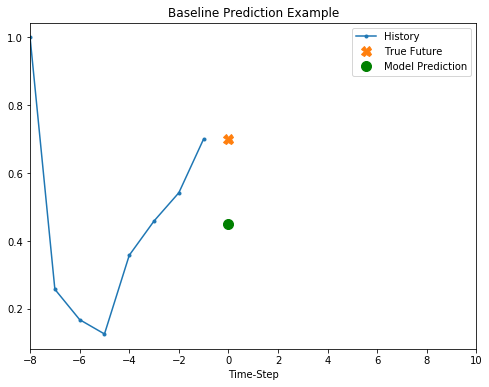

In [24]:
show_plot([X_train[10], y_train[10], baseline(X_train[10])], 0,
           'Baseline Prediction Example')

In [25]:
# Now we build our LSTM model 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=X_train.shape[-2:], name='Train_data')
x = layers.LSTM(10)(inputs)
outputs = layers.Dense(1, name='predictions')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Train_data (InputLayer)      [(None, 8, 1)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 10)                480       
_________________________________________________________________
predictions (Dense)          (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Now we train the model for 10 epochs
EPOCHS = 10
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_val, y_val))

Train on 16063 samples, validate on 15063 samples
Epoch 1/10
16063/16063 [==============================] - 11s 661us/sample - loss: 0.1310 - val_loss: 0.0377
Epoch 2/10
16063/16063 [==============================] - 6s 348us/sample - loss: 0.0334 - val_loss: 0.0307
Epoch 3/10
16063/16063 [==============================] - 6s 345us/sample - loss: 0.0281 - val_loss: 0.0265
Epoch 4/10
16063/16063 [==============================] - 5s 338us/sample - loss: 0.0248 - val_loss: 0.0244
Epoch 5/10
16063/16063 [==============================] - 5s 317us/sample - loss: 0.0233 - val_loss: 0.0231
Epoch 6/10
16063/16063 [==============================] - 5s 307us/sample - loss: 0.0223 - val_loss: 0.0223
Epoch 7/10
16063/16063 [==============================] - 5s 304us/sample - loss: 0.0216 - val_loss: 0.0217
Epoch 8/10
16063/16063 [==============================] - 5s 337us/sample - loss: 0.0212 - val_loss: 0.0218
Epoch 9/10
16063/16063 [==============================] - 6s 382us/sample - loss: 0.0

In [27]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

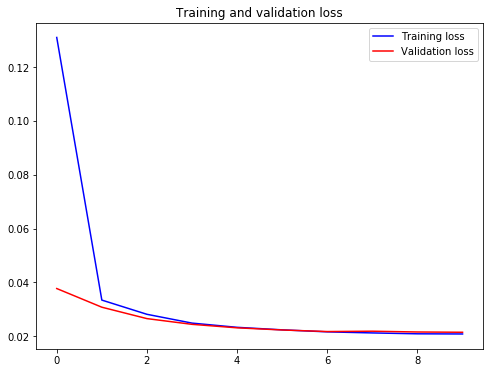

In [28]:
plot_train_history(history, 'Training and validation loss')

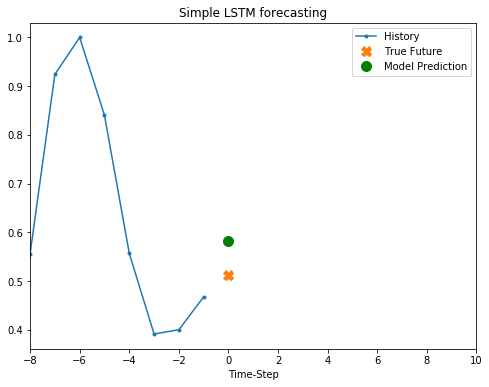

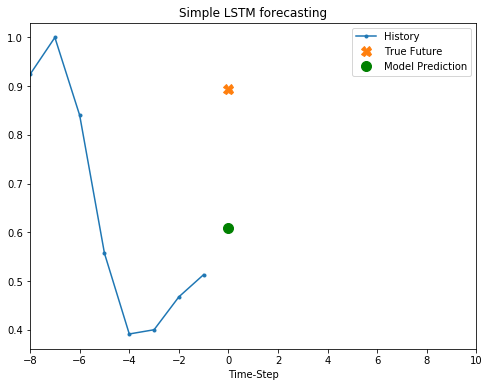

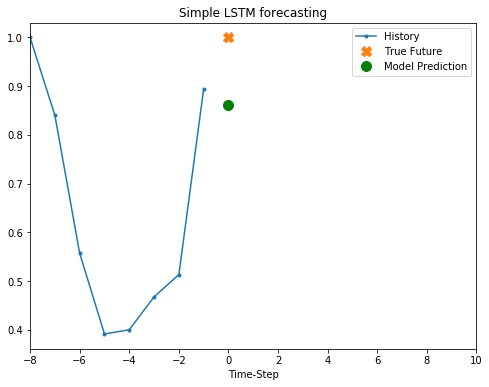

In [29]:
# Forecasting using our Model
for i in range(3):
  plot = show_plot([X_val[i], y_val[i],
                    model.predict(X_val[i].reshape((1,past_history, 1)))],
                   0,
                   'Simple LSTM forecasting')
  plot.show()


# 4 Results and conclusion 

<img src="results.png" style="width: 80000px;"/>

# Appendix

This checklist can guide you through your Machine Learning projects. There are eight main steps:
1. Frame the problem and look at the big picture.
2. Get the data.
3. Explore the data to gain insights.
4. Prepare the data to better expose the underlying data patterns to Machine Learning algorithms.
5. Explore many different models and short-list the best ones.
6. Fine-tune your models and combine them into a great solution.
7. Present your solution.
8. Launch, monitor, and maintain your system.

Obviously, you should feel free to adapt this checklist to your needs.

For more details on the check list check the book of Aurélien Géron : "Hands-On Machine Learning with Scikit-Learn & TensorFlow, CONCEPTS, TOOLS, AND TECHNIQUES TO BUILD INTELLIGENT SYSTEMS"

Also for understaning the training phase in LSTMs check the appendix in the original paper : “Long Short-Term Memory,” S. Hochreiter and J. Schmidhuber (1997).


# References 
Hamid Ettayyebi, Khalid El Himdi, "Artificial Neural Network for Forecasting One Day Ahead of Global Solar Irradiance" (May 29, 2018). Smart Application and Data Analysis for Smart Cities (SADASC'18).

Hamid Ettayyebi, Khalid El Himdi, "Artificial neural networks for forecasting the 24 hours ahead of global solar irradiance", AIP Conference Proceedings, volume: 2056, 2018. doi: 10.1063/1.5084983.

The website for data science competitions: https://www.kaggle.com/